# Supplementary Information: Holmes *et al.* 2017

# 2. Full model fitting

This notebook describes fitting of the Bayesian hierarchical model of the effect of control and treatment, by gene/locus tag, to the full array dataset.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We construct our model to use groupwise (by gene ID) values for $\gamma_{j[i]}$ and $\delta_{j[i]}$, where these coefficients are each drawn from a pooled distribution covering all *gene IDs*. This assumes that the intercept and slope for the relationship between *input* and *output* has the same distribution across all *gene IDs*; this may not be true: we expect that some genes are more responsive than others, in terms of selection. We use a Cauchy distribution (which has fat tails with infinite variance) as a prior on parameter values.

We therefore construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$


* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *gene ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *gene ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *gene ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *gene ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\mu_{\beta}$: the mean slope for all *gene ID*s
* $\sigma_{\beta}$: the standard deviation of the slope for all *gene ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\gamma_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\mu_{\gamma}$: the mean intercept due to *treatment* for each *gene ID*
* $\sigma_{\gamma}$: the standard deviation of the offset for each *gene ID* due to the *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\delta_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\mu_{\delta}$: the mean slope due to *treatment* for each *gene ID*
* $\sigma_{\delta}$: the standard deviation of the slope for each *gene ID* due to *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points
* `J`: `int`, the number of unique locus tags (`J` < `N`)
* `tag`: `int[N]`, an index list of locus tags
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, offset effect on log(intensity) of passing through the experiment for each locus tag/gene
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for all locus tags
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, for each locus tag/gene
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for all locus tags
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset) for each locus tag/gene
* `mu_g`: `real`, an unconstrained value to be fit that represents the mean offset for all locus tags due to *treatment*
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope) for each locus tag/gene
* `mu_d`: `real`, an unconstrained value to be fit that represents the mean slope for all locus tags due to *treatment*
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset for all locus tags
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope for all locus tag
* `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the offset for all locus tags due to *treatment*
* `sigma_d`: `real<lower=0,upper=100>`, standard deviation of the slope for all locus tags due to *treatment*


We also define a `transformed parameter`:

* `y_hat[i] <- b[tag[i]] * x[i] + a[tag[i]] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\sigma_{\delta} \sim U(0, 100)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$


### Load input data for fit

In the cells below we load in the data to be fit, and define useful variables for inspecting/analysing the data later:

* `locus_tags`: the unique locus tags represented in the dataset
* `ntags`: the number of unique locus tags
* `outdir`: path to the directory in which to place model fit output
* `outfile`: path to the model fit output file (pickled dataframe)

In [2]:
# load clean, normalised, indexed data
data = pd.read_csv("datasets/normalised_array_data.tab", sep="\t")  # full dataset

# useful values
locus_tags = data['locus_tag'].unique()
ntags = len(locus_tags)

In [3]:
# Create output directory and filename
outdir = "model_fits"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, 'full_model_fit.pkl')

### Define and fit the Stan model

In the cells below we define the model to be fit, in the Stan language, conduct the fit, and save the fit out to a pickled dataframe>

In [4]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> tag[N];
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_b;
  real mu_g;
  real mu_d;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_g;
  real<lower=0,upper=100> sigma_d;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[tag[i]] + b[tag[i]] * x[i] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ cauchy(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ cauchy(mu_b, sigma_b);

  sigma_g ~ uniform(0, 100);
  g ~ cauchy(mu_g, sigma_g);

  sigma_d ~ uniform(0, 100);
  d ~ cauchy(mu_d, sigma_d);

  y ~ normal(y_hat, sigma);
}
"""

In [5]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': ntags,
                       'tag': data['locus_tag_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [6]:
# run stan fit
#treatment_fit = pystan.stan(model_code=treatment_model,
#                            data=treatment_data_dict,
#                            iter=1000, chains=2,
#                            seed=tools.SEED)

In [7]:
# Save model to file, for reuse# Save fit to file, for reuse
#unpermutedChains = treatment_fit.extract()
#unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
#pickle.dump(unpermutedChains_df, open(outfile, 'wb'))

### Extract the fit

In the cells below we load in the contents of the pickled output (if the fit has already been run), and then extract useful summary information about mean, median, variance, and credibility intervals for the parameter estimates.

In [8]:
# Uncomment the line below to import a previously-fit model
treatment_fit = pickle.load(open(outfile, 'rb'))

In [9]:
# Get summary data for parameter estimates
# use 'fit' for the model fit directly, and 'df'for loaded pickled data
estimates = tools.extract_variable_summaries(treatment_fit, 'df', locus_tags)
estimates.head()

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.029129,0.244940,0.332219,0.426666,0.276330,0.295267,0.097412,0.918105,0.937876,...,0.373606,0.386956,0.091973,-0.090580,-0.062259,-0.055452,-0.036866,-0.059451,-0.058879,0.011430
4705,ECDH10B_RS00020,0.169773,0.272327,0.336390,0.427064,0.303134,0.305796,0.060675,0.923711,0.938501,...,0.385294,0.391275,0.064762,-0.079569,-0.062273,-0.054959,-0.044358,-0.059307,-0.058405,0.008574
5475,ECDH10B_RS00060,0.092371,0.268534,0.338677,0.493763,0.297471,0.307758,0.099552,0.916767,0.938826,...,0.383268,0.389446,0.073516,-0.089941,-0.063986,-0.055564,-0.036741,-0.060844,-0.059464,0.012340
5474,ECDH10B_RS00065,0.091092,0.258078,0.334934,0.449760,0.294165,0.302821,0.081867,0.907745,0.938434,...,0.385307,0.391122,0.106802,-0.090234,-0.062454,-0.054761,-0.040138,-0.059514,-0.058488,0.011435
5469,ECDH10B_RS00070,0.083468,0.265716,0.334018,0.413204,0.291290,0.301167,0.073938,0.918311,0.938084,...,0.373458,0.389639,0.107962,-0.130703,-0.067450,-0.056503,-0.047106,-0.068497,-0.059957,0.022810


In [10]:
# Separate estimates for Sakai and DH10B
sakai_estimates = tools.split_estimates(estimates, 'sakai')
dh10b_estimates = tools.split_estimates(estimates, 'dh10b')

## Inspecting the fit

In the cells below, we visualise the fitted estimates for each of the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ as:

* box plots of median estimates for each locus tag
* relationship between control and treatment effects in Sakai
* plots of 95% credibility interval range against median estimate for each locus tag

### Median parameter estimates

We first inspect the range of fitted estimates to get an overview of the relationships for the data as a whole, and then examine whether this relationship varies by *E. coli* isolate.

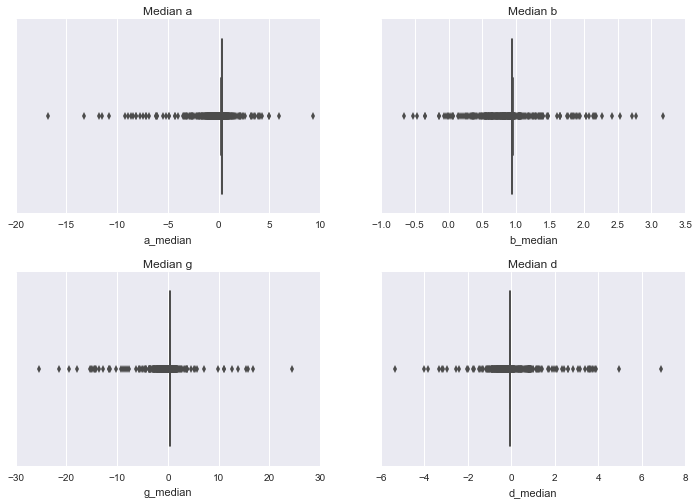

In [11]:
# Visualise median values for parameter estimates
tools.boxplot_medians(estimates)

For this fit we can see that most median values of $\alpha$ (control intercept), $\gamma$ (treatment intercept), and $\delta$ (treatment slope) are close to zero. Most values of $\beta$ are close to (but slightly less than) unity. This implies that:

* The linear relationship between input and output intensity due to the control effects (growth only) is, for most genes in the experiment, a slight reduction of output intensity with respect to input intensity value [median $\alpha$ ≈ 0, median $\beta$ ≈ 1]
* For most genes in the experiment there is no treatment effect due to exposure to the plant [median $\gamma$ ≈ 0, median $\delta$ ≈ 0]

There are, however, a considerable number of outlying median values for each parameter, which suggests that a number of genes have associated parameter values that are affected by either control (growth) or treatment (passage).

#### DH10B

Considering the Sakai estimates only:

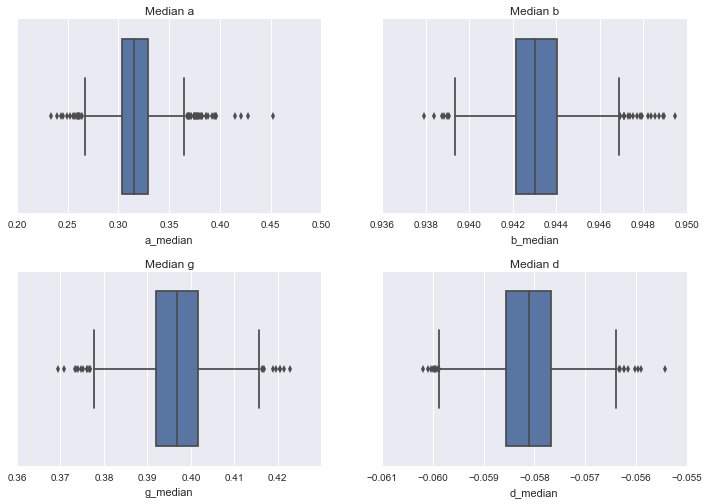

In [12]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(dh10b_estimates)

#### Sakai

Considering the Sakai estimates only:

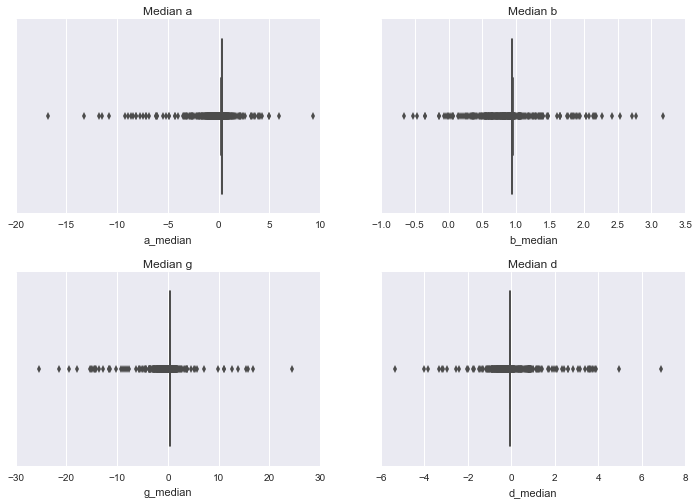

In [13]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(sakai_estimates)

From these boxplots it is clear that the median parameter estimates for DH10B are extremely restricted in their range:

* $0.2 < \alpha < 0.5$
* $0.936 < \beta < 0.95$
* $0.36 < \gamma < 0.43$
* $-0.061 < \delta < 0.06$

As before the control effect appears to be essentially neutral, in that the output intensity is almost a 1:1 linear relationship with the input intensity, but it is striking that the median estimates of $\gamma$ and $\delta$ are very close to zero, suggesting that passage (treatment) has almost no effect on this relationship, for any DH10B locus tag.

This is exactly what would be expected for DH10B as the carrier isolate.

By contrast, the median parameter estimates for Sakai are extremely variable, though the bulk of estimates are close to the values seen for DH10B:

* $-20 < \alpha < 10$
* $-1 < \beta < 3.5$
* $-30 < \gamma < 30$
* $-6 < \delta < 8$

This indicates the expected result, that strong variability of control and treatment effects are effectively confined to the Sakai BAC fragments.

It is expected that some genes/operons may be relatively advantageous in either growth (control) or passage (treatment) conditions, or both. We can visualise the relationships between parameter estimates for control and treatment effects in scatterplots.

In [14]:
def plot_treatment_vs_control(df):
    """Plot median treatment vs control parameters in a 2x2 matrix"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()
    fig.subplots_adjust(hspace=0.3)
    
    for idx, xvar, yvar, ax in zip(range(4),
                                   ['a_median', 'a_median',
                                    'b_median', 'b_median'],
                                   ['g_median', 'd_median',
                                    'g_median', 'd_median'],
                                   axes):
        ax.scatter(df[xvar], df[yvar], alpha=0.2)
        ax.set_xlabel(xvar)
        ax.set_ylabel(yvar)

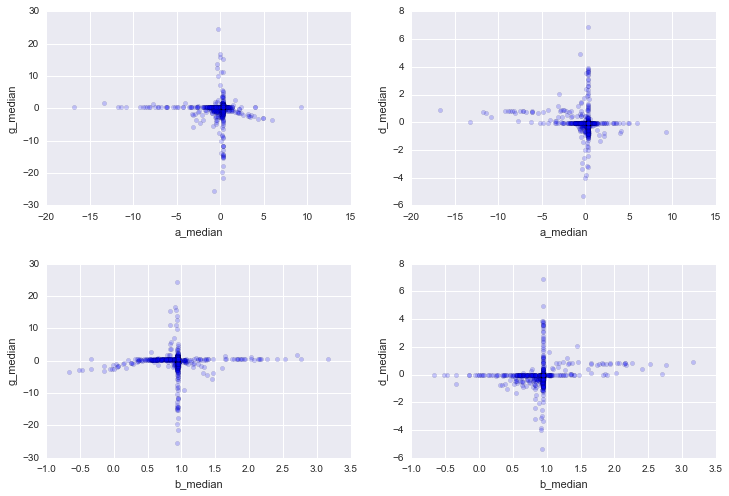

In [15]:
# Plot estimated parameters for treatment effects against control effects for Sakai
plot_treatment_vs_control(sakai_estimates)

The strong cross-like distributions indicate that most parameter estimates that vary from those of the bulk are orthogonal: deviation of the control experiment parameters is not associated with deviation of the treatment effect parameters.

However, there is a group of estimates in the plots of `d_median` against `a_median` and `b_median` that suggest an additional effect is in play. Several locus tags with median estimates of $\delta \approx 1$ are also associated with large values of `b_median`. This might reflect a situation where the variability in the estimates of $\beta$ and $\delta$ is large, and the uncertainty is being partitioned across the two parameters, or it could indicate that there is genuinely a strong positive effect on the BAC-carrying organisms under both conditions.

We can inspect this group of locus tags directly, to examine whether the 95% credibility intervals for those parameter estimates include 1 (for $\beta$) or 0 (for $\delta$). If that is the case for both estimates on a locus tag, then we might consider that the median estimates are the result of partitioning variability across both estimates.

In [16]:
# Extract the suspect locus tags, which have large estimates for d_median and b_median
suspects = sakai_estimates.loc[(sakai_estimates['b_median'] > 1) &
                               (sakai_estimates['d_median'] > 0.5)]
suspects = suspects[['locus_tag',
                     'b_median', 'b_2.5pc', 'b_97.5pc',
                     'd_median', 'd_2.5pc', 'd_97.5pc']]
suspects

,locus_tag,b_median,b_2.5pc,b_97.5pc,d_median,d_2.5pc,d_97.5pc
2992,ECs0218,2.177616,1.648019,2.656389,0.696648,0.212189,1.158068
4460,ECs0237,1.173647,0.795524,2.199794,0.547856,-0.064777,2.297449
1021,ECs1357,2.531182,1.957337,3.062126,0.732440,0.409551,1.048997
4768,ECs1556,1.330507,0.882774,2.302321,0.812953,0.216107,2.266111
163,ECs1557,3.166764,2.772861,3.590428,0.891258,0.679918,1.240506
915,ECs3222,2.768258,2.434587,3.095956,0.658634,0.426298,0.869889
886,ECs3232,1.035740,0.934710,1.115305,1.664662,1.193798,2.156372
875,ECs3233,1.318883,0.935725,2.206321,0.771997,-0.062680,2.113179
627,ECs3239,1.380284,0.939670,2.222052,0.804196,-0.065722,2.274725
615,ECs3242,1.469263,0.939575,2.401819,0.881952,0.117384,2.169571


From the table that results, only a few locus tags have parameter estimate variability that suggests it could take the value of the bulk of the population:

* ECs0237
* ECs3233
* ECs3239

Otherwise the 95% CI for each of the parameter estimates suggests we should have some confidence in their values being unusually high for both control and treatment effects, so potentially being genes that confer a general, and not specifically plant-associated advantage on the carrier isolate.

## Identifying locus tags that confer an advantage under treatment and/or control

We use a 50% credibility interval to determine whether the effect of a gene on passage is likely to be positive. Under this assumption, the middle 50% of the parameter estimates for $\delta$ do not include zero. We label these `trt_pos`.

Likewise, we use a 50% credibility interval to determine whether the effect of a gene on surviving growth (control) is an outlier. If the 50% CI for $\beta$ does not include the 97.5 percentile for all estimates of $\beta$ in this dataset, we consider that the effect of the gene on surviving growth conditions is positive. We label these `ctl_pos`.

We create a third category: `combined`: genes with a positive effect on both growth and passage.

In [17]:
# Label locus tags with positive effects
sakai_estimates = tools.label_positive_effects(sakai_estimates)

We can count the number of locus_tags in each of the groups:

In [18]:
# Count locus tags in each of the positive groups
counts = [sum(sakai_estimates[col]) for col in ('trt_pos', 'ctl_pos', 'combined')]
print("treatment positive: {0}\ncontrol positive: {1}\nboth: {2}".format(*counts))

treatment positive: 72
control positive: 52
both: 24


which indicates, with these assumptions, that 72 genes have a positive effect on passage (treatment), 24 of these also have a positive effect in the growth (control) step, and a further 28 have a positive effect only on the growth step.

### Plotting distribution of effects

We can show the estimated effects, and our confidence in those estimates, on a rough representation of the genome by plotting those values for each locus tag in genome order.

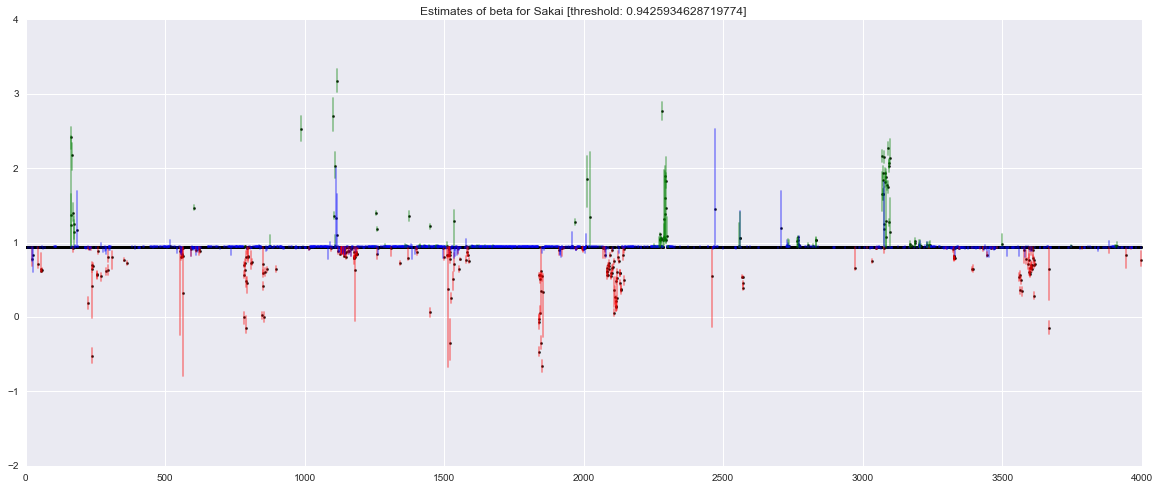

In [19]:
# Plot genome-wide estimates of beta for Sakai
beta_thresh = np.median(sakai_estimates['b_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(sakai_estimates, 'b', 'Estimates of beta for Sakai', beta_thresh)

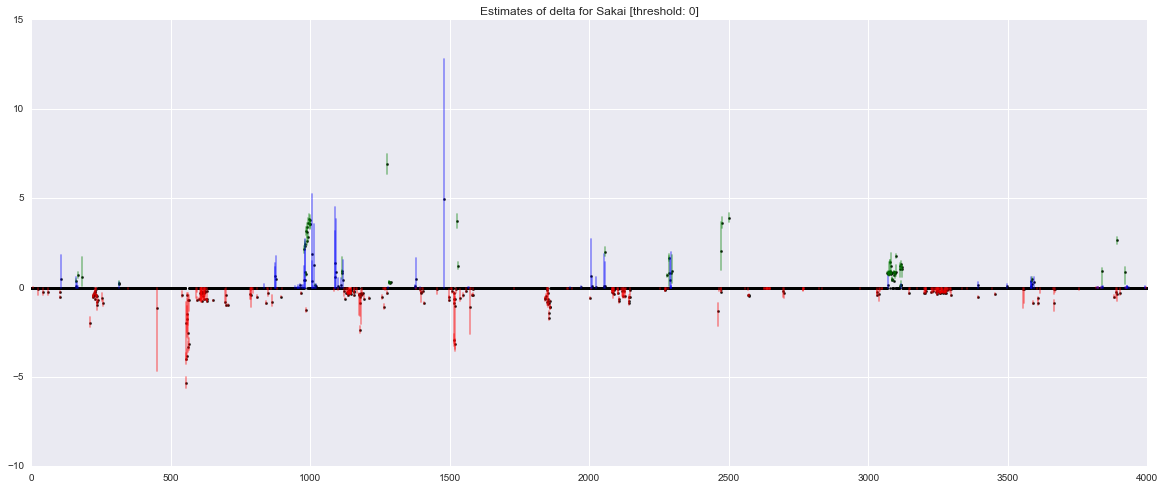

In [20]:
# Plot genome-wide estimates of delta for Sakai
tools.plot_parameter(sakai_estimates, 'd', 'Estimates of delta for Sakai')